In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [26]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

- LeakyReLU 활성화 함수가 좀 더 훈련 결과를 향상시키는 경향이 있음
- 일반 ReLU(0또는 1)와 달리 작은 기울기를 사용하여, 그라디언트가 사라지는 것을 막기 때문
- 핸즈 온 머신러닝 416p: 0.01정도의 기울기를 부여하여, LeakyReLU(z) = max(az, z)로 정의

In [27]:
def build_generator(img_shape, z_dim):
    model = Sequential()

    model.add(Dense(128, input_dim = z_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [28]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Flatten(input_shape = img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [29]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [30]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer = Adam())

In [31]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4, z_dim = 100): # z_dim은 generator에도 설정되어있으므로 일치시킬 필요가 있음
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5 # 이미지 범위를 [0,1] 사이로 스케일 조절, 기존에는 -1~1 사이
    
    fig, axs = plt.subplots(image_grid_rows,
                    image_grid_columns,
                    figsize=(4, 4),
                    sharey=True,
                    sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i ,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [32]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (X_train, _), (_, _) = mnist.load_data()

    # 정규화 진행. [0,255] -> [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3) 

    real = np.ones((batch_size, 1)) # 진짜 이미지는 0으로 분류
    
    fake = np.zeros((batch_size, 1)) # 가짜 이미지는 1로 분류

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 최소 0, 최대 X_train.shape[0]에서 batch_size개의 값 추출
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake) # real에 대한 loss와 fake에 대한 loss 양쪽 모두에 대한 측정이 필요

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" % (iteration+1, d_loss, 100*accuracy, g_loss))

            sample_images(generator)


1000 [D 손실: 0.386689, 정확도: 80.86%] [G 손실: 2.801539]
2000 [D 손실: 0.436831, 정확도: 80.08%] [G 손실: 2.478981]
3000 [D 손실: 0.338368, 정확도: 85.55%] [G 손실: 2.189354]
4000 [D 손실: 0.292098, 정확도: 87.89%] [G 손실: 2.560860]
5000 [D 손실: 0.419132, 정확도: 81.25%] [G 손실: 1.934750]
6000 [D 손실: 0.331401, 정확도: 85.55%] [G 손실: 2.278919]
7000 [D 손실: 0.373236, 정확도: 82.42%] [G 손실: 2.530756]
8000 [D 손실: 0.340280, 정확도: 84.77%] [G 손실: 2.585691]
9000 [D 손실: 0.298823, 정확도: 86.33%] [G 손실: 2.790455]
10000 [D 손실: 0.377935, 정확도: 81.25%] [G 손실: 2.530781]
11000 [D 손실: 0.340631, 정확도: 85.94%] [G 손실: 2.521329]
12000 [D 손실: 0.564407, 정확도: 71.48%] [G 손실: 1.891271]
13000 [D 손실: 0.373398, 정확도: 83.20%] [G 손실: 2.426615]
14000 [D 손실: 0.350160, 정확도: 86.33%] [G 손실: 2.355741]
15000 [D 손실: 0.464093, 정확도: 78.91%] [G 손실: 2.346299]
16000 [D 손실: 0.297156, 정확도: 86.72%] [G 손실: 2.311167]
17000 [D 손실: 0.401127, 정확도: 81.64%] [G 손실: 2.343015]
18000 [D 손실: 0.371933, 정확도: 84.38%] [G 손실: 2.311000]
19000 [D 손실: 0.403622, 정확도: 81.64%] [G 손실: 2.071678]
20

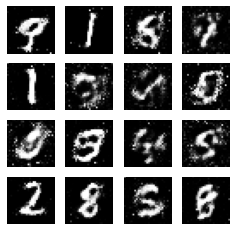

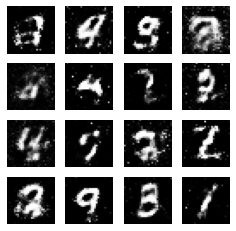

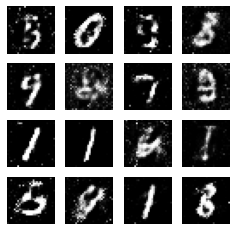

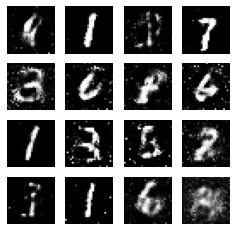

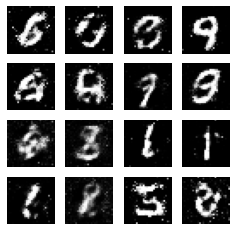

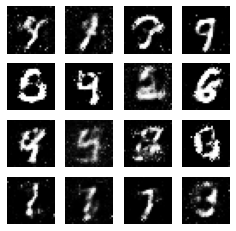

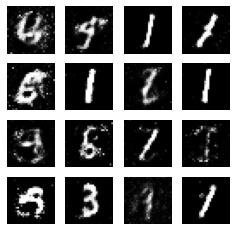

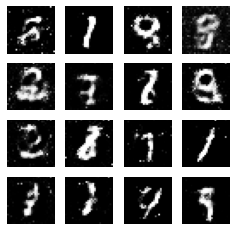

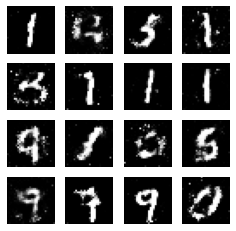

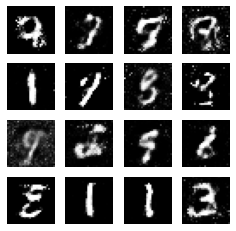

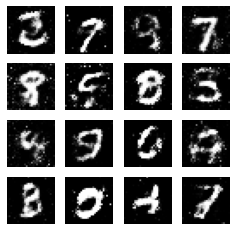

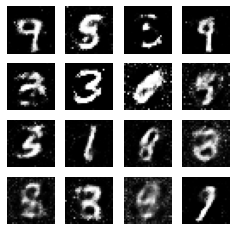

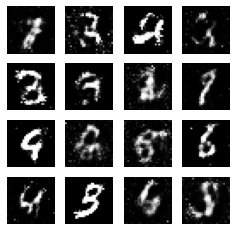

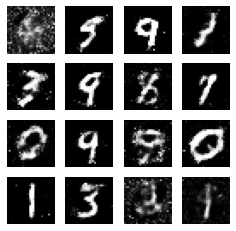

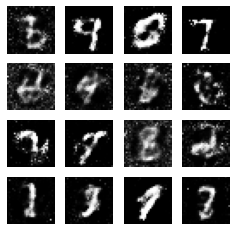

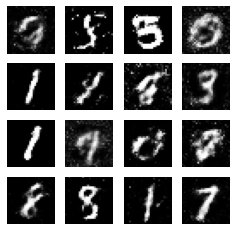

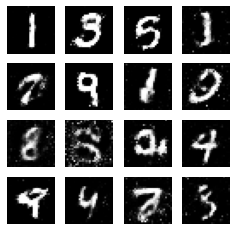

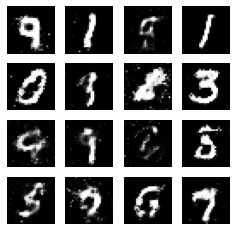

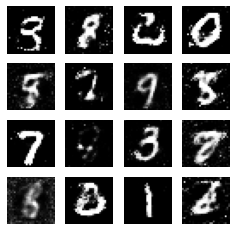

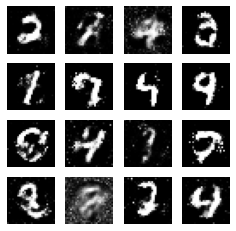

In [35]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [34]:
batch_size = 16

(X_train, _), (_, _) = mnist.load_data()

# 정규화 진행. [0,255] -> [-1, 1]
X_train = X_train / 127.5 - 1.0
X_train = np.expand_dims(X_train, axis=3) 

np.random.randint(0, X_train.shape[0], batch_size)

array([54185, 15986, 39706, 57905, 21638, 24424, 55273, 59777, 14856,
       11748, 28509, 25871, 21659, 12130, 59039, 55150])